In [1]:
try:
     from dlroms import*
except:
     !pip install git+https://github.com/NicolaRFranco/dlroms.git
     from dlroms import*

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
%cd './gdrive/MyDrive/Colab Notebooks/DL-ROMs/brain_damage'

/content/gdrive/MyDrive/Colab Notebooks/DL-ROMs/brain_damage


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch

In [5]:
# Set device and seed

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
torch.manual_seed(0)

In [6]:
# Domain definition

loop = lambda v: np.concatenate((v, v[[0]]))
brain = np.load("brainshape.npz")
domain = fe.polygon(loop(brain["main"][::9])) - fe.polygon(loop(brain["hole1"][::9])) - fe.polygon(loop(brain["hole2"][::8]))

In [7]:
# Meshes and FEM spaces definition

h = 0.02
mesh_H = fe.mesh(domain, stepsize=h)
Vh_H = fe.space(mesh_H, 'CG', 1)
mesh_C = fe.mesh(domain, stepsize=5/2*h)
Vh_C = fe.space(mesh_C, 'CG', 1)
nh_H, nh_C = Vh_H.dim(), Vh_C.dim()
print(nh_H, nh_C)

3378 2315


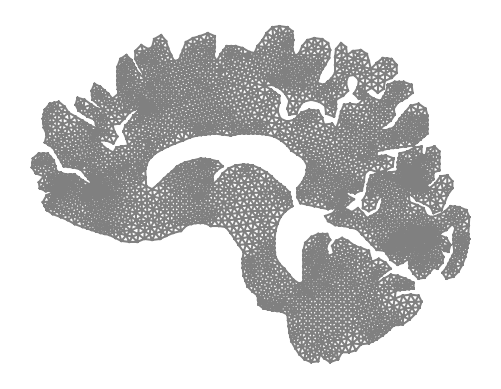

In [11]:
fe.plot(mesh_H)

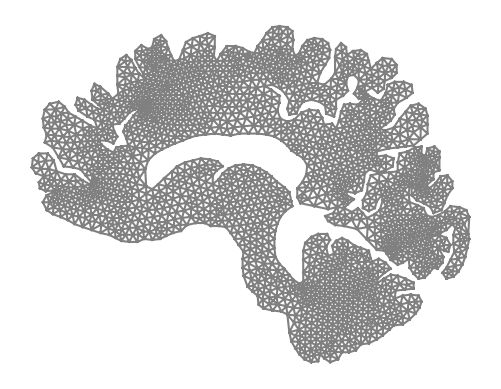

In [12]:
fe.plot(mesh_C)

In [13]:
# Load snapshots for training

data_train = np.load("snapshots_train_H.npz")
N_train = data_train['mu'].shape[0]
mu_train, u_train = data_train['mu'].astype(np.float32), data_train['u'].astype(np.float32)
mu_train, u_train = torch.tensor(mu_train).to(device), torch.tensor(u_train).to(device)

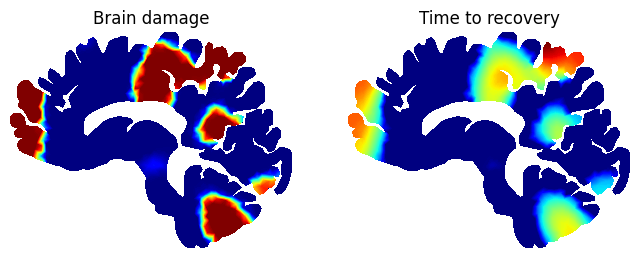

In [ ]:
# Print a random training snapshot

which = 4
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title("Brain damage")
fe.plot(1 + 0 * mu_train[which], Vh_H, cmap='jet_r', vmin=0, vmax=1)
fe.plot(mu_train[which], Vh_H, cmap='jet_r')
plt.subplot(1, 2, 2)
plt.title("Time to recovery")
fe.plot(u_train[which], Vh_H, cmap='jet')

In [14]:
# Load snapshots for testing

data_test = np.load("snapshots_test.npz")
N_test = data_test['mu'].shape[0]
mu_test, u_test = data_test['mu'].astype(np.float32), data_test['u'].astype(np.float32)
mu_test, u_test = torch.tensor(mu_test).to(device), torch.tensor(u_test).to(device)

# High-fidelity model

In [44]:
# DLROM definition

# Initial supports: 0.05, 0.1, 0.05

layer_1 = Geodesic(domain, Vh_H, Vh_C, support=0.05) # default activation: leakyReLU
layer_2 = Geodesic(domain, Vh_C, Vh_C, support=0.1)
layer_3 = Geodesic(domain, Vh_C, Vh_H, support=0.05, activation=None)

In [45]:
# Train the DLROM with high-fidelity snapshots (with random initialization)

model = DFNN(layer_1, layer_2, layer_3)
model.He()

# model.to(device) # NOT WORKING
if device.type == "cuda":
  model.cuda()
else:
  model.cpu()

model.train(mu_train, u_train, ntrain=N_train, epochs=100, loss=mse(euclidean), verbose=True)

		Train		Test
Epoch 100:	4.49e-01	nan.

>> ETA: 0.76s.

Training complete. Elapsed time: 1 minutes 15.64 seconds.


In [46]:
# Use the model for prediction

model.eval()

with torch.no_grad():
  u_pred_train = model(mu_train)
  u_pred = model(mu_test)

error_train = torch.norm(u_train - u_pred_train, dim=1) / torch.norm(u_train, dim=1)
error_test = torch.norm(u_test - u_pred, dim=1) / torch.norm(u_test, dim=1)
print('Relative training error: {:.2f}%'.format(100 * torch.mean(error_train)))
print('Relative test error: {:.2f}%'.format(100 * torch.mean(error_test)))

Relative training error: 7.20%
Relative test error: 9.56%


In [ ]:
### 0.05, 0.1, 0.05 ###
# 300 epochs (4m): training 5.96%, test 9.92%... overfitting!
# 100 epochs (1m 20): training 7.04%, test 9.37%... BEST
### 0.1, 0.2, 0.1 ###
# 300 epochs (6m 20): training 5.33%, test 13.65%
# 100 epochs (2m): training 7.18%, test 12.19%
### 0.1, 0.1, 0.1 ####
# 300 epochs (5m 25): training 5.32%, test 12.49%
# 100 epochs (1m 45): training 6.88%, test 10.90%
### 0.05, 0.05, 0.05 ###
# 300 epochs (3m 50): training 6.61%, test 10.42%
# 100 epochs (1m 15): training 7.67%, test 9.32%... BEST
### 0.05, 0.01, 0.05 ###
# 300 epochs...
# 100 epochs (1m 10): training 9.77%, test 10.93%

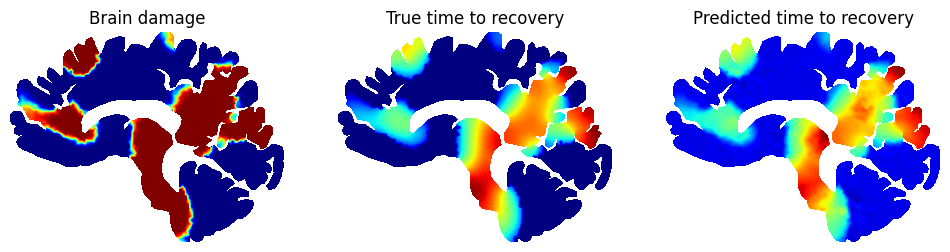

In [ ]:
# Print a random test snapshot against the corresponding prediction

which = 10
plt.figure(figsize=(12, 5))
plt.subplot(1, 3, 1)
plt.title("Brain damage")
fe.plot(1 + 0 * mu_test[which], Vh_H, cmap='jet_r', vmin=0, vmax=1)
fe.plot(mu_test[which], Vh_H, cmap='jet_r')
plt.subplot(1, 3, 2)
plt.title("True time to recovery")
fe.plot(u_test[which], Vh_H, cmap='jet')
plt.subplot(1, 3, 3)
plt.title("Predicted time to recovery")
fe.plot(u_pred[which], Vh_H, cmap='jet')

In [ ]:
# Train the DLROM with half of the high-fidelity snapshots (with random initialization)

mu_train = mu_train[0:-1:2, :]
u_train = u_train[0:-1:2, :]

model = DFNN(layer_1, layer_2, layer_3)
model.He()

#model.to(device) # NOT WORKING
if device.type == "cuda":
  model.cuda()
else:
  model.cpu()

model.train(mu_train, u_train, ntrain=N_train, epochs=300, loss=mse(euclidean), verbose=True) # default optimizer: LBFGS

model.eval()

with torch.no_grad():
  u_pred = model(mu_test)

error_test = torch.norm(u_test - u_pred, dim=1) / torch.norm(u_test, dim=1)
print('Relative test error: {:.2f}%'.format(100 * torch.mean(error_test)))

		Train		Test
Epoch 300:	2.05e-01	nan.

>> ETA: 0.54s.

Training complete. Elapsed time: 2 minutes 43.22 seconds.
Relative test error: 15.03%


# Dense model

In [ ]:
# Dense NN definition

#layer_1_d = Dense(Vh_H.dim(), Vh_C.dim())
layer_1 = Geodesic(domain, Vh_H, Vh_C, support=0.05)
layer_2_d = Dense(Vh_C.dim(), Vh_C.dim())
#layer_3_d = Dense(Vh_C.dim(), Vh_H.dim()) # CUDA out of memory
layer_3 = Geodesic(domain, Vh_C, Vh_H, support=0.05, activation=None)

In [ ]:
# Training of a dense NN

#model_d = DFNN(layer_1_d, layer_2_d, layer_3)
model_d = DFNN(layer_1, layer_2_d, layer_3)
model_d.He()

if device.type == "cuda":
  model_d.cuda()
else:
  model_d.cpu()

model_d.train(mu_train, u_train, ntrain=N_train, epochs=150, loss=mse(euclidean), verbose=True)

		Train		Test
Epoch 150:	2.93e-01	nan.

>> ETA: 2.45s.

Training complete. Elapsed time: 6 minutes 8.23 seconds.


In [ ]:
# Use the model for prediction

model_d.eval()

with torch.no_grad():
  u_pred_train = model_d(mu_train)
  u_pred = model_d(mu_test)

error_train = torch.norm(u_train - u_pred_train, dim=1) / torch.norm(u_train, dim=1)
error_test = torch.norm(u_test - u_pred, dim=1) / torch.norm(u_test, dim=1)
print('Relative training error: {:.2f}%'.format(100 * torch.mean(error_train)))
print('Relative test error: {:.2f}%'.format(100 * torch.mean(error_test)))

Relative training error: 5.99%
Relative test error: 18.39%


In [ ]:
# With 300 epochs (11m ca): training 3.99%, test 18.45%
# With 150 epochs (6m ca): training 5.99%, test 18.39%

In [ ]:
# Deterministic initialization

def Det(chi, V_coarse, V_fine, r):

  M = 0

  coords_coarse = V_coarse.tabulate_dof_coordinates() # (Mh + 1) pairs
  coords_fine = V_fine.tabulate_dof_coordinates() # (Nh + 1) pairs

  dim = len(coords_coarse[0]) # x, y
  for j in range(dim):
    dj = coords_coarse[:, j].reshape(-1, 1) - coords_fine[:, j].reshape(1, -1) # shape (Mh + 1) ** 2 x (Nh + 1) ** 2
    M = M + dj**2

  M = np.sqrt(M)
  M = M * (M < r) - (M >= r) # set the distances for the points outside the support to -1

  nonzeros = len(chi.loc[0]) # number of active weights
  weights = np.zeros((chi.in_d, chi.out_d), dtype='float32')

  for i in range(nonzeros):
    weights[chi.loc[0][i], chi.loc[1][i]] = np.exp(-M[chi.loc[0][i], chi.loc[1][i]]) # w = exp{-d}

  for i in range(chi.out_d):
    weights[:, i] = weights[:, i] / np.sum(weights[:, i]) # weights normalization

  weights = weights.reshape(-1)
  weights = weights[np.where(weights != 0)] # keep only nonzero weights

  return weights